# Coding: Vision Transformers (Oct 14)
## MLP-Mixer (https://arxiv.org/abs/2105.01601)

Mount drive (to store results)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install dependencies

In [2]:
!pip install timm

     |████████████████████████████████| 376 kB 5.2 MB/s 


Imports

In [3]:
import csv
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets,transforms
import torch.utils.tensorboard as tb
import time
from os import path

import shutil
import os

import timm 

from tqdm import tqdm

%pylab inline


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


Download TinyImageNet dataset

In [ ]:
# TinyImageNet
if not path.isdir("./data/tiny-imagenet-200"):
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
    !unzip -q tiny-imagenet-200.zip -d ./data/

--2021-10-09 14:39:10--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  10.5MB/s    in 23s     

2021-10-09 14:39:33 (10.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
#@title Hyperparameters (TODO: find reasonable values)
batch_size = "256" #@param ["64", "128", "256"]
learning_rate = "0.001" #@param ["0.0001", "0.001", "0.01", "0.1"]

Create dataloader for selected dataset; set fitting input/output sizes for selected dataset; set name for log file based on dataset, hyperparameters

In [ ]:
dataset = "STL-10" #@param ["STL-10", "TinyImageNet", "CIFAR-10"]

# create datasets
if dataset == "STL-10":
    training_dataset = datasets.STL10(root='./data/STL10', split='train', transform=transforms.ToTensor(), download=True)
    validation_dataset = datasets.STL10(root='./data/STL10', split='test', transform=transforms.ToTensor(), download=True)
    in_size = 96
    num_classes = 10
if dataset == "CIFAR-10":
    training_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=True, download=True, transform=transforms.ToTensor())
    validation_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=False, download=True, transform=transforms.ToTensor())
    in_size = 32
    num_classes = 10
if dataset == "TinyImageNet":
    training_dataset = datasets.ImageFolder("./data/tiny-imagenet-200/train", transform=transforms.Compose([transforms.ToTensor()]))
    validation_dataset = datasets.ImageFolder("./data/tiny-imagenet-200/val", transform=transforms.Compose([transforms.ToTensor()]))
    in_size = 64
    num_classes = 200

# create dataloaders
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=int(batch_size), shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=int(batch_size), shuffle=False)

# set name for log file
result_filename = "MLP-Mixer_" + dataset + "_batch" + batch_size + "_learnrate" + learning_rate

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Dataloader Test

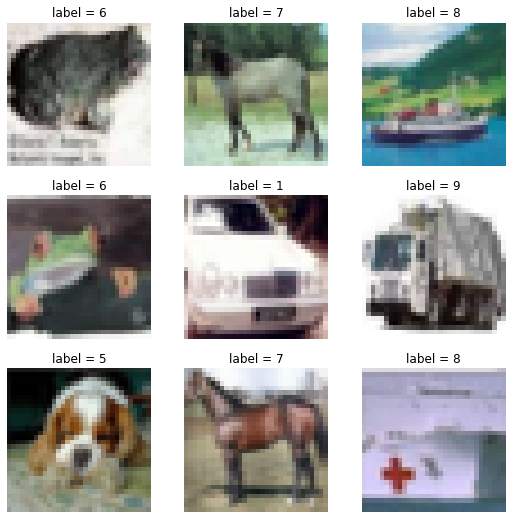

In [ ]:
train_data, train_label = next(iter(training_loader))

to_image = transforms.ToPILImage()

figure(figsize=(9,9))
# Plot the first 9 images
for i, (data, label) in enumerate(zip(train_data[:9],train_label[:9])):
    subplot(3,3,1+i)
    imshow(to_image(data))
    title('label = %d'%label)
    axis('off')

Load tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir . --port 6006

Train and log results

In [ ]:
epochs = 10


for learning_rate in [0.0001, 0.001, 0.01]:
    for batch_size in [256, 512]:
        # set name for log file
        result_filename = "MLP-Mixer_" + dataset + "_batch" + str(batch_size) + "_learnrate" + str(learning_rate)

        if not os.path.exists("/content/drive/My Drive/MLP-Mixer_Results/" + result_filename + ".csv"):
            # create S/16 model; training B/16 takes forever
            model = timm.models.mlp_mixer.mixer_s16_224(pretrained=False, num_classes=num_classes, img_size=in_size)

            # create optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            # create loss function
            loss_fn = nn.CrossEntropyLoss()

            # create dataloaders
            training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
            validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

            # create loggers
            train_logger = tb.SummaryWriter(path.join(".", 'train_' + result_filename + '_{}'.format(time.strftime('%m-%d-%H-%M'))), flush_secs=1)
            valid_logger = tb.SummaryWriter(path.join(".", 'valid_' + result_filename + '_{}'.format(time.strftime('%m-%d-%H-%M'))), flush_secs=1)

            results =  []
            losses = []

            global_step = 0

            for e in range(epochs):
                running_loss = 0.0
                running_corrects = 0.0
                val_running_loss = 0.0
                val_running_corrects = 0.0
                
                for inputs, labels in tqdm(training_loader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)

                    loss = loss_fn(outputs, labels) 

                    train_logger.add_scalar('loss', loss, global_step)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data).item()

                    losses.append(loss.item())

                    global_step += 1

                # validation
                with torch.no_grad(): # No gradient for validation
                    for val_inputs, val_labels in validation_loader:
                        val_inputs = val_inputs.to(device)
                        val_labels = val_labels.to(device)

                        val_outputs = model(val_inputs)

                        val_loss = loss_fn(val_outputs, val_labels)
                        
                        _, val_preds = torch.max(val_outputs, 1)
                        val_running_loss += val_loss.item()
                        val_running_corrects += torch.sum(val_preds == val_labels.data).item()
                    
                epoch_loss = running_loss/len(training_dataset)
                epoch_acc = running_corrects/ len(training_dataset)

                train_logger.add_scalar('accuracy', epoch_acc, global_step)
                
                val_epoch_loss = val_running_loss/len(validation_dataset)
                val_epoch_acc = val_running_corrects/ len(validation_dataset)
                
                valid_logger.add_scalar('accuracy', val_epoch_acc, global_step)
                
                epoch_results = {
                    'Epoch': e,
                    'Training Loss': round(epoch_loss, 3),
                    'Validation Loss': round(val_epoch_loss, 3),
                    'Training Accuracy': round(epoch_acc,3),
                    'Validation Accuracy': round(val_epoch_acc,3)
                    }
                
                print(epoch_results)
                results.append(epoch_results)

            print("Writing logs...")

            csv_columns = ['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy',  'Validation Accuracy']
            try:
                with open(result_filename + ".csv", 'w', newline='') as csvfile:
                    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
                    writer.writeheader()
                    for data in results:
                        writer.writerow(data)
            except IOError:
                print("I/O error")

            with open(result_filename + "_losses.txt", "w") as f:
                with loss_val in losses:
                    f.write(str(loss_val) + "\n")

            torch.save(model, result_filename + ".th")

            # save results to drive
            try:
                if not os.path.exists('/content/drive/My Drive/MLP-Mixer_Results/'):
                    os.mkdir('/content/drive/My Drive/MLP-Mixer_Results/')
                shutil.copyfile(result_filename + ".th", "/content/drive/My Drive/MLP-Mixer_Results/" + result_filename + ".th")
                shutil.copyfile(result_filename + ".csv", "/content/drive/My Drive/MLP-Mixer_Results/" + result_filename + ".csv")
                shutil.copyfile(result_filename + "_losses.txt", "/content/drive/My Drive/MLP-Mixer_Results/" + result_filename + "_losses.txt")
            except Exception as e:
                print(e)

            print("Done training " + result_filename)